In [1]:
# We start by importing the libraries that we will need in the following code 
import pandas as pd  
import numpy as np  
import seaborn as sns
import math
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from sklearn import metrics
import scipy
import lightgbm
import statistics
import datetime as dt

**In this part we import the data from the csv file, process it so that it can be interpreted by the code and apply the appropriate regressors.** 

In [2]:
# We read the training and test data 
data = pd.read_csv("../input/prediction-du-taux-dazote-2/data_6.csv",encoding='latin-1',sep=';')
data_test=pd.read_csv("../input/prediction-du-taux-dazote-2/test_6.csv",encoding='latin-1',sep=';')

In [3]:
#Remove columns with many empty cells or repeated columns 
data=data.drop(columns=['Mos.','Grp.Crop','birth.day','second.feed.1.date','second.feed..2.date'])
data_test=data_test.drop(columns=['Mos.','Grp.Crop','birth.day','second.feed.1.date','second.feed..2.date'])

In [4]:
#In this code cell we make a text treatment of the data by replacing the spaces, normalize the texts to avoid the redundancy and convert the whole after in type Float
columns=data.columns
columns_test=data_test.columns

for i in range(0,len(columns)):
  try:
    data[columns[i]]=data[columns[i]].str.replace(' ','')
  except:
    pass
for i in range(0,len(columns_test)):
  try:
    data_test[columns_test[i]]=data_test[columns_test[i]].str.replace(' ','')
  except:
    pass
for i in range(0,len(columns)):
  try:
    data[columns[i]]=data[columns[i]].str.capitalize()
  except:
    pass
for i in range(0,len(columns)):
  try:
    data_test[columns_test[i]]=data_test[columns_test[i]].str.capitalize()
  except:
    pass
for i in range(1,len(columns)):
  try:
    data[columns[i]]=data[columns[i]].astype(float)
  except:
    pass
for i in range(1,len(columns)):
  try:
    data_test[columns_test[i]]=data_test[columns_test[i]].astype(float)
  except:
    pass

In [5]:
#We replace the empty cells of the data represented by - by np.nan then by the mean of each column 
data=data.replace(159753,np.nan) # It is noted that a manipulation on excel was made to replace the - by a number (159753)
data_test=data_test.replace(159753,np.nan)

data=data.replace(np.nan,data.mean(skipna=True))
data_test=data_test.replace(np.nan,data_test.mean(skipna=True))

In [6]:
#We parse the dates of the data in datetime and we make a mapping 

data['sampling.date']= pd.to_datetime(data['sampling.date'])
data_test['sampling.date']= pd.to_datetime(data_test['sampling.date'])

data['sampling.date']=data['sampling.date'].map(dt.datetime.toordinal)
data_test['sampling.date']=data_test['sampling.date'].map(dt.datetime.toordinal)

In [7]:
#We factor the columns whose values are presented as groups 
data = pd.get_dummies(data, columns=['Sampling.Timing.Vs.second.feed.timing','second.feed..2','Province','Agroecological.zones','Crop','Regime','Code_Stage','Base.Feed','Second.feed.1'])
data_test = pd.get_dummies(data_test, columns=['Sampling.Timing.Vs.second.feed.timing','second.feed..2','Province','Agroecological.zones','Crop','Regime','Code_Stage','Base.Feed','Second.feed.1'])

In [8]:
# In the column PROVINCE some provinces are not present in the test data so we add them factorized then parse them into uint8
M=[0]*238
data_test['Province_Elkelaadessraghna']=M
data_test["Province_M'diq159753fnideq"]=M
data_test['Province_Rehamna']=M
data_test['Province_Elkelaadessraghna']=data_test['Province_Elkelaadessraghna'].astype(np.uint8)
data_test["Province_M'diq159753fnideq"]=data_test["Province_M'diq159753fnideq"].astype(np.uint8)
data_test['Province_Rehamna']=data_test['Province_Rehamna'].astype(np.uint8)

In [9]:
#We define a certain order of the data 
columns=list(data.columns)
columns.sort()
data=data[columns]
columns_test=list(data_test.columns)
columns_test.sort()
data_test=data_test[columns_test]

In [10]:
#We take a global look at the data 
data.describe()

,AI,Agroecological.zones_Défavorable,Agroecological.zones_Favorable,Agroecological.zones_Favorablesupérieur,Agroecological.zones_Interemédiaire,Agroecological.zones_Montagne,B1,B2,B3,B4,...,X4,X5,X6,X7,X8,X9,pH,sampling.date,second.feed..2_No,second.feed..2_Yes
count,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,...,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.00000,2096.000000,2096.000000,2096.000000
mean,2.327358,0.110687,0.295324,0.178912,0.312023,0.103053,575.020268,909.989172,924.005051,3607.147866,...,0.138856,0.119893,0.117756,0.103572,0.147371,0.293319,9.48029,737726.352099,0.992366,0.007634
std,0.936159,0.313819,0.456297,0.383370,0.463430,0.304101,223.813042,335.408622,524.803199,824.552735,...,0.072268,0.028343,0.033717,0.057638,0.054604,0.062456,0.40471,197.646595,0.087057,0.087057
min,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,151.680000,250.130000,132.830000,227.130000,...,0.002000,0.079000,0.068000,0.036000,0.042000,0.027000,6.60000,737426.000000,0.000000,0.000000
25%,1.660000,0.000000,0.000000,0.000000,0.000000,0.000000,449.052500,737.112500,625.557500,3189.195000,...,0.088000,0.104000,0.098000,0.066000,0.113000,0.255000,9.48029,737510.000000,1.000000,0.000000
50%,2.260000,0.000000,0.000000,0.000000,0.000000,0.000000,575.020268,909.989172,924.005051,3607.147866,...,0.133000,0.113000,0.111000,0.089000,0.137000,0.294000,9.48029,737731.000000,1.000000,0.000000
75%,2.790000,0.000000,1.000000,0.000000,1.000000,0.000000,616.387500,961.707500,1005.005000,3934.302500,...,0.158000,0.126000,0.127000,0.125000,0.167250,0.332000,9.50000,737845.000000,1.000000,0.000000
max,8.120000,1.000000,1.000000,1.000000,1.000000,1.000000,3440.610000,5393.500000,6346.250000,7614.580000,...,0.629000,0.397000,0.399000,0.568000,0.582000,0.617000,10.90000,738127.000000,1.000000,1.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Columns: 154 entries, AI to second.feed..2_Yes
dtypes: float64(94), int64(2), uint8(58)
memory usage: 1.7 MB


In order to have a better prediction we will try to reduce the number of columns by calculating some soil indicators 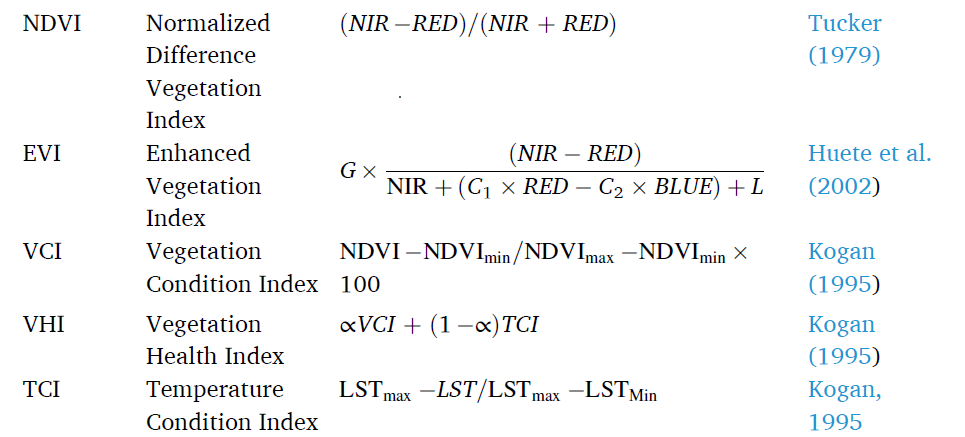
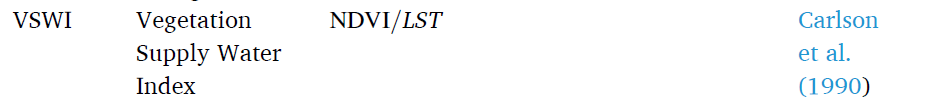
Source : https://reader.elsevier.com/reader/sd/pii/S1470160X20309729?token=89B25AE7E53EBBB80D34AB86C7ECDE8487597A711142CA24C3A6E4E050E3B2AFC3024DBAA1A5158774B5CC81B92DE2C0&originRegion=eu-west-1&originCreation=20220114142410

In [12]:
def add_features(data):
  #Vegetation Condition Index
  data['VCI']=((data['NDVI']-data['NDVI_min'])/(data['NDVI_max']-data['NDVI_min']))*100
  data['VCI']=data['VCI'].astype(float)

  data['VCI']=data['VCI'].replace(np.nan,data['VCI'].mean())
  data['VCI']=data['VCI'].replace(np.inf,data['VCI'].mean())
  data['VCI']=data['VCI'].replace(-np.inf,data['VCI'].mean())




  #Temperatur Condition Index
  LST=pd.DataFrame()
  LST['LST_DAY_jan_mars']=data['LST_DAY_jan_mars']
  LST['LST_DAY_oct_dec']=data['LST_DAY_oct_dec']
  LST['LST_Night_jan_mars']=data['LST_Night_jan_mars']
  LST['LST_Night_oct_dec']=data['LST_Night_oct_dec']
  LST_MAX=LST.max(axis=1)+273
  LST_MIN=LST.min(axis=1)+273
  data['TCI']=(LST_MAX-data['LST'])/(LST_MAX-LST_MIN)

  data['TCI']=data['TCI'].replace(np.nan,data['TCI'].mean())
  data['TCI']=data['TCI'].replace(np.inf,data['TCI'].mean())
  data['TCI']=data['TCI'].replace(-np.inf,data['TCI'].mean())



  #Vegetation Health Index
  data['VHI']=(data['TCI']+data['VCI'])*0.5
  data['VHI']=data['VHI'].astype(float)

  data['VHI']=data['VHI'].replace(np.nan,data['VHI'].mean())
  data['VHI']=data['VHI'].replace(np.inf,data['VHI'].mean())
  data['VHI']=data['VHI'].replace(-np.inf,data['VHI'].mean())




  #Vegetation Supply Water Index
  data['VSWI']=data['NDVI']/data['LST']
  data['VSWI']=data['VSWI'].astype(float)


  data['VSWI']=data['VSWI'].replace(np.nan,data['VSWI'].mean())
  data['VSWI']=data['VSWI'].replace(np.inf,data['VSWI'].mean())
  data['VSWI']=data['VSWI'].replace(-np.inf,data['VSWI'].mean())




  #Leaf Area Index
  data['LAI']=(data['AI']-data['LAI_min'])/(data['LAI_max']-data['LAI_min'])
  data['LAI']=data['LAI'].astype(float)

  data['LAI']=data['LAI'].replace(np.nan,data['LAI'].mean())
  data['LAI']=data['LAI'].replace(np.inf,data['LAI'].mean())
  data['LAI']=data['LAI'].replace(-np.inf,data['LAI'].mean())
  return data

**Exploratory Data Analysis**

In [13]:
def show_correlogram(df):
    plt.figure(figsize=(150,150), dpi= 50)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True, cbar=False
    )
    plt.title('Correlogram between features', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [14]:
#The correlation between the different variables 
#show_correlogram(data)

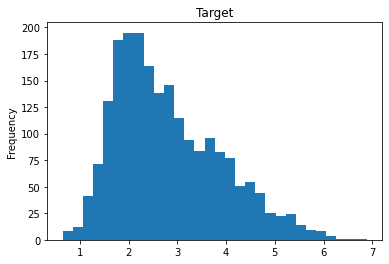

In [15]:
#We see the distribution of the column in the data 
data['Target'].plot(kind='hist', bins=30, title='Target')
plt.show()

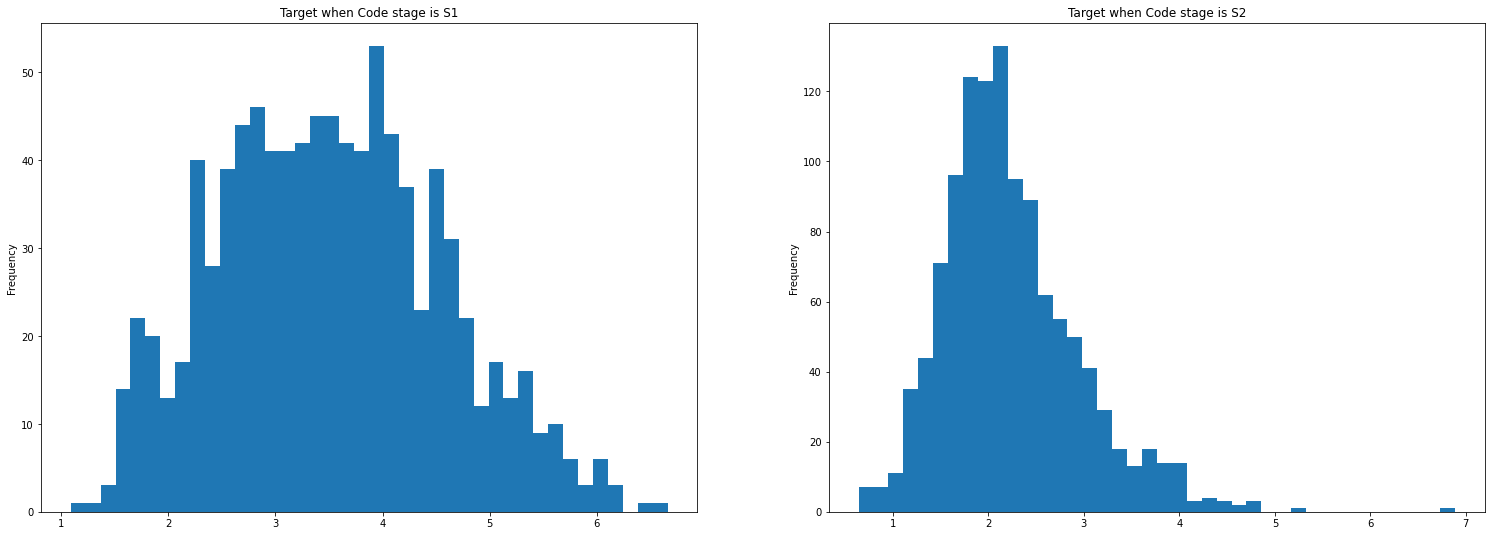

In [16]:
#We see the distribution of Target taking into account the variables with the most correlation (in modulus)
plt.figure(figsize=(40,9))
plt.subplot(131)
data[data['Code_Stage_S1'] ==1]['Target'].plot(kind='hist', bins=40, title='Target when Code stage is S1')
plt.subplot(132)
data[data['Code_Stage_S2'] ==1]['Target'].plot(kind='hist', bins=40, title='Target when Code stage is S2')
plt.show()


In [17]:
def plot_create(x, y):
    plt.plot(x, y, '-', label=y.name)
def process_visualisation(df, ID):
    plt.figure(figsize=(14, 6))
    plt.title('Code_Stage_S1 is {}'.format(ID))
    plot_create(df[df['Code_Stage_S1'] ==ID]['Column1'],
                df[df['Code_Stage_S1'] ==ID]['Target'])
    plt.legend()
    plt.ylabel('Value')
    plt.show()

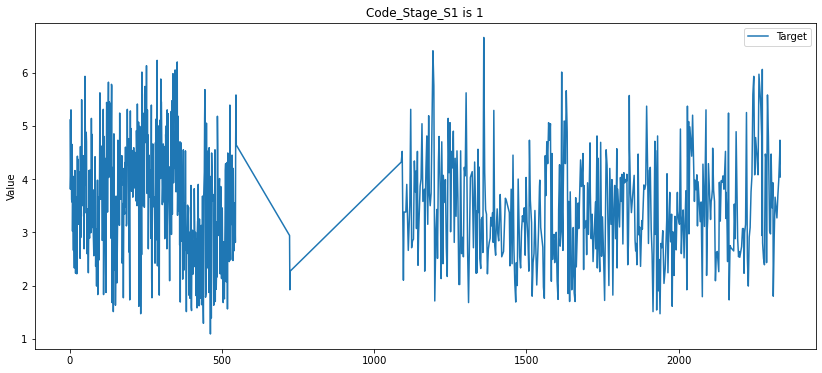

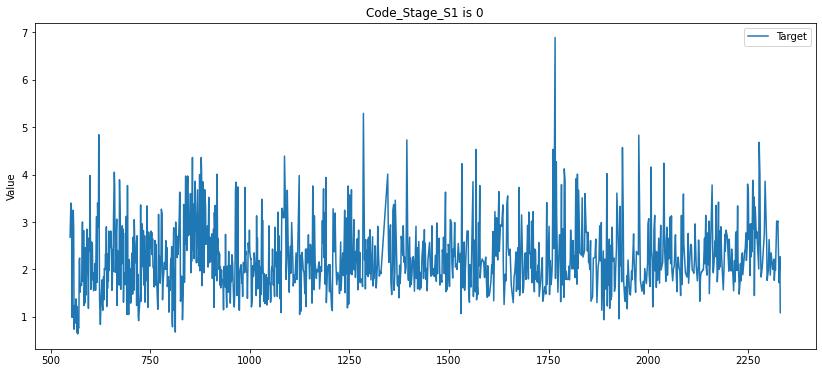

In [18]:
process_visualisation(data, 1)
process_visualisation(data, 0)


**Train and test section** 

In [19]:
#we add the indicators already calculated to the data and the data_test
data,data_test = add_features(data),add_features(data_test)
data=data.drop(columns=[])
data_test=data_test.drop(columns=[])

data.replace(np.nan,data.mean(),inplace=True)
data_test.replace(np.nan,data_test.mean(),inplace=True)



In [20]:
#We define our dependent and independent variables 
X,X_Kaggle = data,data_test
X = X.drop('Target', axis=1)
columns=X.columns
columns_test=X_Kaggle.columns
Y = data['Target']
X=X[[i for i in columns if i!='Target' and i!='Column1']]
X_Kaggle=X_Kaggle[[i for i in columns if i!='Target'and i!='Column1']]

In [21]:
#X_train,  X_val, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [22]:
#We initialize several regression models 
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor(max_depth=15, random_state=0)
catboost_model = CatBoostRegressor(loss_function='RMSE',verbose=0,iterations=1000,learning_rate=0.1)
xgb_model = xgb.XGBRegressor(boosting_type='dart',eta=0.1,min_child_weight=2,colsample_bytree=1,n_estimators=350,normalize_type='forest') 
lgb_model = lightgbm.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=350)
dummy_model = DummyRegressor()
rf_model=RandomForestRegressor()


In [23]:
#A function that calculates the RMSE on a part of the data (testing data)
def train_and_score(model):
    model.fit(X_train, Y_train)
    return np.sqrt(metrics.mean_squared_error(Y_test, model.predict(X_test)))

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,random_state=0)
display(
    pd.DataFrame(data=([train_and_score(linear_model)],
                       [train_and_score(tree_model)],
                       [train_and_score(catboost_model)],
                       [train_and_score(xgb_model)],
                       [train_and_score(lgb_model)], 
                       [train_and_score(dummy_model)],
                       [train_and_score(rf_model)]
                      ),
                 columns=['Result RMSE'],
                 index=['Linear', 'Tree', 'CatBoost','XGBOOST','LightGBOOST', 'Dummy','Random Forest'])
)

[19:46:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "normalize_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Result RMSE
Linear,0.829052
Tree,1.053571
CatBoost,0.801247
XGBOOST,0.816442
LightGBOOST,0.812698
Dummy,1.133465
Random Forest,0.787862


In [25]:
train_and_score(catboost_model)

0.8012470843676696

In [31]:
# First import necessary libraries
import pandas as pd
from sklearn.ensemble import StackingRegressor
# Decision trees
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
# Neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from keras.layers import concatenate
from keras.models import Model
# Wrapper to make neural network compitable with StackingRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# Lineral model as meta-learn
from sklearn.linear_model import LinearRegression
# Create generic dataset for regression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
# Split into validation set
X_train, X_val, y_train, y_val = train_test_split(X, Y,
                                                  test_size=0.1,
                                                  random_state=0)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6206181657771109467
]
Num GPUs Available:  0


In [27]:
def create_neural_network(input_shape=510, depth=10, batch_mod=2, num_neurons=250, drop_rate=0.1, learn_rate=.01,
                      r1_weight=0.02,
                      r2_weight=0.02):
      '''A neural network architecture built using keras functional API'''
      act_reg = regularizers.l1(r2_weight)
      kern_reg = regularizers.l1(r1_weight)
      
      inputs = tf.keras.Input(shape=(input_shape,))
      batch1 = tf.keras.layers.BatchNormalization()(inputs)
      hidden1 = Dense(num_neurons, activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(batch1)
      dropout1 = Dropout(drop_rate)(hidden1)
      hidden2 = Dense(int(num_neurons/2), activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(dropout1)
      
      skip_list = [batch1]
      last_layer_in_loop = hidden2
      
      for i in range(depth):
          added_layer = concatenate(skip_list + [last_layer_in_loop])
          skip_list.append(added_layer)
          b1 = None
          #Apply batch only on every i % N layers
          if i % batch_mod == 2:
              b1 = tf.keras.layers.BatchNormalization()(added_layer)
          else:
              b1 = added_layer
          
          h1 = Dense(num_neurons, activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(b1)
          d1 = Dropout(drop_rate)(h1)
          h2 = Dense(int(num_neurons/2), activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(d1)
          d2 = Dropout(drop_rate)(h2)
          h3 = Dense(int(num_neurons/2), activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(d2)
          d3 = Dropout(drop_rate)(h3)
          h4 = Dense(int(num_neurons/2), activation='relu', kernel_regularizer=kern_reg, activity_regularizer=act_reg)(d3)
      last_layer_in_loop = h4
      c1 = concatenate(skip_list + [last_layer_in_loop])
      output = Dense(1, activation='sigmoid')(c1)
      
    
      model = Model(inputs=inputs, outputs=output)
      optimizer = tf.keras.optimizers.Adam()
      optimizer.learning_rate = learn_rate
      
      model.compile(optimizer=optimizer,
                    loss='mse',
                    metrics=['accuracy'])
      return model

In [28]:
def get_stacking(input_shape=None):
      '''A stacking model that consists of CatBoostRegressor,
      XGBRegressor, a linear model, and some neural networks'''
      # First we create a list called "level0", which consists of our base models"
      # These models will get passed down to the meta-learner later
      level0 = list()
      level0.append(('cat', CatBoostRegressor(verbose=False)))
      level0.append(('cat2', CatBoostRegressor(loss_function='RMSE',verbose=0,iterations=4500,learning_rate=0.01)))
      level0.append(('xgb', XGBRegressor()))
      level0.append(('xgb2', XGBRegressor(boosting_type='dart',eta=0.1,min_child_weight=2,colsample_bytree=1,n_estimators=100,normalize_type='forest')))
      level0.append(('linear', LinearRegression()))
  #Create 5 neural networks using our function above
      for i in range(5):
          # Wrap our neural network in a Keras Regressor to make it
          #compatible with StackingRegressor
          keras_reg = KerasRegressor(
                  create_neural_network, # Pass in function
                  input_shape=input_shape, # Pass in the dimensions to above function
                  epochs=6,
                  batch_size=32,
                  verbose=False)
          keras_reg._estimator_type = "regressor"
          # Append to our list
          level0.append(('nn_{num}'.format(num=i), keras_reg))
  # The "meta-learner" designated as the level1 model
      # In my experience Linear Regression performs best
      # but feel free to experiment with other models
      level1 = LinearRegression()
  # Create the stacking ensemble
      model = StackingRegressor(estimators=level0, final_estimator=level1, cv=2, verbose=1)
      return model

In [29]:
#Get our input dimensions for neural network
input_dimensions = len(X_train.columns)
# Create stacking model
model = get_stacking(input_dimensions)
model.fit(X_train, y_train.values.ravel())
# Creating a temporary dataframe so we can see how each of our models performed
temp = pd.DataFrame(y_val)
# The stacked models predictions, which should perform the best
temp['stacking_prediction'] = model.predict(X_val)
# Get each model in the stacked model to see how they individually perform
for m in model.named_estimators_:
        temp[m] = model.named_estimators_[m].predict(X_val)
# See how each of our models correlate with our target
print(temp.corr()['Target'])
# See what our meta-learner is thinking (the linear regression)
for coef in zip(model.named_estimators_, model.final_estimator_.coef_):
    print(coef)

[19:48:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "boosting_type", "normalize_type" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




KeyboardInterrupt: 

In [ ]:
Y_Kaggle=model.predict(X_Kaggle)

In [ ]:
model = CatBoostRegressor(verbose=0,iterations=3000)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid,
                                       X=X_train,
                                       y=Y_train,
                                       plot=True)

In [ ]:
catboost_model.fit(X,Y)

In [ ]:
xgbr = xgb.XGBRegressor(eta=0.1,min_child_weight=2,colsample_bytree=1,n_estimators=350) 
print(xgbr)

In [ ]:
#xgbr.fit(X,Y)
Y_Kaggle=catboost_model.predict(X_Kaggle)

In [ ]:
R=pd.DataFrame()
R['Id']=data_test['Column1']
R['Target']=Y_Kaggle

In [ ]:
R=R.sort_values(by=['Id'])
R['Id']=R['Id'].astype(int)

In [ ]:

print(statistics.mean(data['Target']))
print(min(data['Target']))
print(max(data['Target']))
print(statistics.stdev(data['Target']))

In [ ]:
print(2.827311918014238)
print(1.069901704788208)
print(5.231398582458496)
print(0.8468073288586955)

In [ ]:
print(statistics.mean(R['Target']))
print(min(R['Target']))
print(max(R['Target']))
print(statistics.stdev(R['Target']))

In [ ]:
R.to_csv("/content/Classeur).csv",index=False)